Training One-Class SVM...
Training with features: ['acceleration_magnitude', 'angular_velocity_magnitude', 'motion_intensity', 'orientation_change', 'accel_change', 'orientation_change_rate', 'roll', 'pitch', 'jerk_magnitude']
Number of features: 9

Parameters: nu=0.01, gamma=scale
Score: 0.169

Parameters: nu=0.01, gamma=auto
Score: 0.122

Parameters: nu=0.01, gamma=0.1
Score: 0.122

Parameters: nu=0.01, gamma=0.01
Score: 0.359

Parameters: nu=0.05, gamma=scale
Score: 0.169

Parameters: nu=0.05, gamma=auto
Score: 0.116

Parameters: nu=0.05, gamma=0.1
Score: 0.123

Parameters: nu=0.05, gamma=0.01
Score: 0.343

Parameters: nu=0.1, gamma=scale
Score: 0.175

Parameters: nu=0.1, gamma=auto
Score: 0.118

Parameters: nu=0.1, gamma=0.1
Score: 0.123

Parameters: nu=0.1, gamma=0.01
Score: 0.265

Best parameters: {'nu': 0.01, 'gamma': 0.01}
Best score: 0.35911602209944754

Applying multi-criteria validation...
Applying temporal filtering...
Applying cooldown period...

Prediction Analysis:
Origi

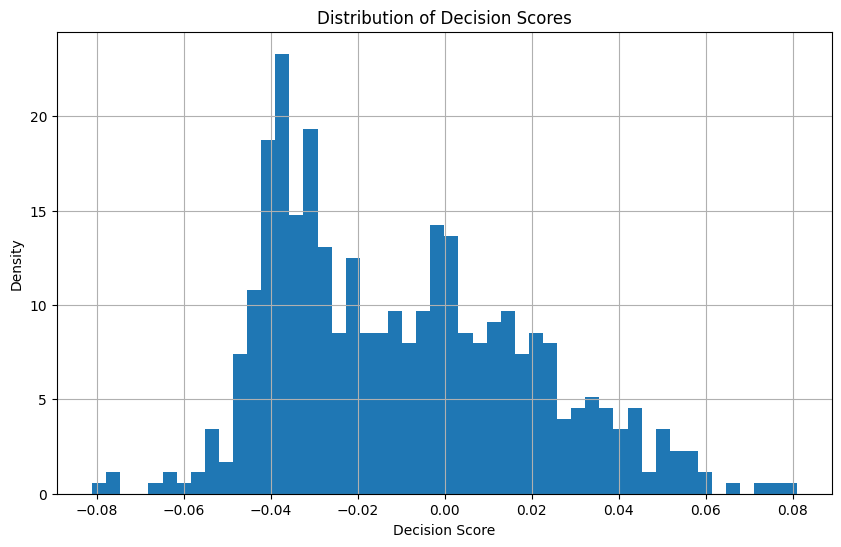


Saving model and related objects...


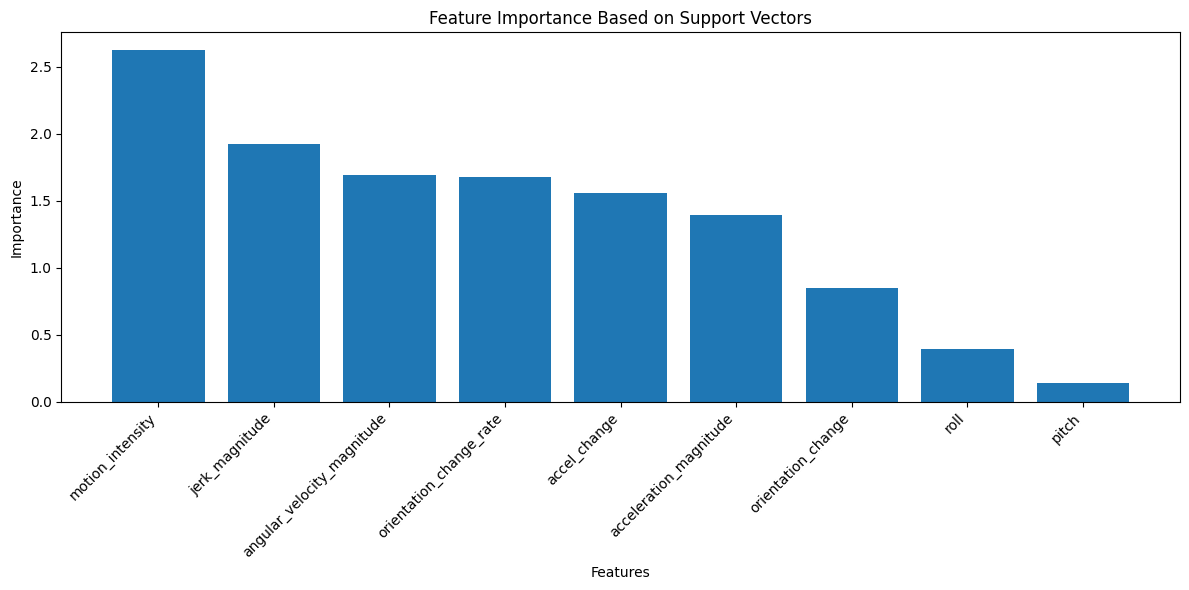


Top 5 most important features:
                      feature  importance
2            motion_intensity    2.625565
8              jerk_magnitude    1.921711
1  angular_velocity_magnitude    1.693927
5     orientation_change_rate    1.675002
4                accel_change    1.553521


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import joblib
from general import *

def engineer_features(data):
    """
    Create additional relevant features for fall detection
    """
    data = data.copy()
    
    # Create composite features
    data['motion_intensity'] = data['acceleration_magnitude'] * data['angular_velocity_magnitude']
    data['orientation_change'] = np.sqrt(data['roll']**2 + data['pitch']**2)
    
    # Create rate of change features
    data['accel_change'] = data['acceleration_magnitude'].diff().fillna(0)
    data['orientation_change_rate'] = data['orientation_change'].diff().fillna(0)
    
    return data

def prepare_features(data):
    """
    Select and prepare the most relevant features for fall detection
    """
    primary_features = [
        'acceleration_magnitude',
        'angular_velocity_magnitude',
        'motion_intensity',
        'orientation_change',
        'accel_change',
        'orientation_change_rate',
        'roll',
        'pitch',
        'jerk_magnitude'
    ]
    
    return data[primary_features]

def apply_temporal_filter(predictions, window_size=5):
    """
    Apply temporal filtering to reduce sporadic false positives
    """
    filtered_predictions = np.zeros_like(predictions)
    for i in range(len(predictions)):
        window = predictions[max(0, i-window_size):min(len(predictions), i+window_size)]
        filtered_predictions[i] = 1 if np.mean(window) > 0.5 else 0
    return filtered_predictions

def apply_cooldown(predictions, cooldown_period=20):
    """
    Apply cooldown period after detecting a fall
    """
    processed_predictions = predictions.copy()
    last_fall = -cooldown_period
    for i in range(len(predictions)):
        if predictions[i] == 1:
            if i - last_fall < cooldown_period:
                processed_predictions[i] = 0
            else:
                last_fall = i
    return processed_predictions

def validate_predictions(predictions, data, accel_threshold=2.0, orientation_threshold=45.0):
    """
    Validate fall predictions using multiple criteria
    """
    validated_predictions = predictions.copy()
    
    # Only keep predictions where acceleration is significant
    validated_predictions &= (data['acceleration_magnitude'] > accel_threshold)
    
    # Check for significant orientation change
    orientation_change = np.sqrt(data['roll']**2 + data['pitch']**2)
    validated_predictions &= (orientation_change > orientation_threshold)
    
    return validated_predictions

def train_oneclass_svm(data):
    """
    Train and tune One-Class SVM with enhanced feature selection
    """
    # Engineer additional features
    enhanced_data = engineer_features(data)
    
    # Select relevant features
    X = prepare_features(enhanced_data)
    
    print("Training with features:", X.columns.tolist())
    print(f"Number of features: {len(X.columns)}")
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Filter training data to include only significant motion
    significant_motion_mask = enhanced_data['acceleration_magnitude'] > 0.5
    X_scaled_filtered = X_scaled[significant_motion_mask]
    
    # Define parameter grid
    param_grid = {
        'nu': [0.01, 0.05, 0.1],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    
    # Grid search
    best_score = -np.inf
    best_params = None
    best_model = None
    
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_scaled_filtered)
            
            predictions = model.predict(X_scaled)
            predictions = (predictions + 1) // 2
            score = np.mean(predictions)
            
            print(f"\nParameters: nu={nu}, gamma={gamma}")
            print(f"Score: {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = {'nu': nu, 'gamma': gamma}
                best_model = model
    
    print("\nBest parameters:", best_params)
    print("Best score:", best_score)
    
    return best_model, scaler, X.columns.tolist()

def analyze_predictions(model, X_scaled, data, window_size=5, cooldown_period=20):
    """
    Analyze model predictions with all filtering approaches
    """
    # Get initial predictions
    predictions = model.predict(X_scaled)
    predictions = (predictions + 1) // 2
    
    # Apply multi-criteria validation
    print("\nApplying multi-criteria validation...")
    validated_predictions = validate_predictions(predictions, data)
    
    # Apply temporal filtering
    print("Applying temporal filtering...")
    filtered_predictions = apply_temporal_filter(validated_predictions, window_size)
    
    # Apply cooldown
    print("Applying cooldown period...")
    final_predictions = apply_cooldown(filtered_predictions, cooldown_period)
    
    # Get decision scores
    scores = model.decision_function(X_scaled)
    
    print("\nPrediction Analysis:")
    print("Original predictions:")
    print(f"Number of falls detected: {sum(predictions == 1)}")
    print("\nAfter validation:")
    print(f"Number of falls detected: {sum(validated_predictions == 1)}")
    print("\nAfter temporal filtering:")
    print(f"Number of falls detected: {sum(filtered_predictions == 1)}")
    print("\nAfter cooldown:")
    print(f"Number of falls detected: {sum(final_predictions == 1)}")
    
    # Plot decision scores distribution
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, density=True)
    plt.title('Distribution of Decision Scores')
    plt.xlabel('Decision Score')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
    return final_predictions, scores

# Main execution
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('dataset/combined_training_data.csv')
    
    # Train model
    print("Training One-Class SVM...")
    model, scaler, features = train_oneclass_svm(data)
    
    # Prepare features for prediction
    enhanced_data = engineer_features(data)
    X = prepare_features(enhanced_data)
    X_scaled = scaler.transform(X)
    
    # Analyze predictions with all filtering approaches
    predictions, scores = analyze_predictions(model, X_scaled, enhanced_data)
    
    # Save model and related objects
    print("\nSaving model and related objects...")
    joblib.dump(model, 'oneclass_svm2.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    joblib.dump(features, 'features.joblib')
    
    # Plot feature importance
    sv_importance = np.abs(model.dual_coef_[0]).dot(np.abs(model.support_vectors_))
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': sv_importance
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance Based on Support Vectors')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 most important features:")
    print(feature_importance.head())

In [23]:
def organize_columns2(data):
    """
    Organize DataFrame columns keeping only essential features and computing
    new features for fall detection
    
    Parameters:
    data (pd.DataFrame): Input DataFrame with all columns
    
    Returns:
    pd.DataFrame: DataFrame with organized columns and new features
    """
    # Copy the input DataFrame
    organized_data = data.copy()
    
    # Drop environmental columns
    columns_to_drop = ['temperature', 'humidity', 'pressure', 'altitude', 'session_id']
    organized_data = organized_data.drop(columns=columns_to_drop, errors='ignore')
    
    # Compute essential new features
    # Motion intensity (combination of acceleration and rotation)
    organized_data['motion_intensity'] = organized_data['acceleration_magnitude'] * organized_data['angular_velocity_magnitude']
    
    # Overall orientation change
    organized_data['orientation_change'] = np.sqrt(
        organized_data['roll']**2 + organized_data['pitch']**2
    )
    
    # Define essential features to keep
    essential_features = [
        'acceleration_magnitude',    # Base acceleration
        'angular_velocity_magnitude', # Base angular velocity
        'roll',                      # Base orientation
        'pitch',                     # Base orientation
        'jerk_magnitude',            # Rate of acceleration change
        'motion_intensity',          # Combined motion
        'orientation_change',        # Combined orientation
        'fall'                       # Target variable
    ]
    
    # Keep only essential features
    organized_data = organized_data[essential_features]
    
    print("\nEssential features kept:")
    print(organized_data.columns.tolist())
    
    return organized_data

In [24]:
def test_predictions(test_data, model_path='oneclass_svm_model.joblib', 
                    scaler_path='scaler.joblib', features_path='features.joblib'):
    """
    Test One-Class SVM predictions on new data
    
    Parameters:
    test_data (pd.DataFrame): Test dataset with 'fall' labels
    model_path (str): Path to saved model
    scaler_path (str): Path to saved scaler
    features_path (str): Path to saved features list
    """
    # Load model and related objects
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    expected_features = joblib.load(features_path)
    
    # Print features for debugging
    print("Expected features:", expected_features)
    print("Available features:", test_data.columns.tolist())
    
    # Check for missing features
    missing_features = [f for f in expected_features if f not in test_data.columns]
    if missing_features:
        print(f"\nWarning: Missing features: {missing_features}")
        print("Adding missing features with default value 0")
        for feature in missing_features:
            test_data[feature] = 0
    
    # Prepare test data with exactly the same features as training
    X_test = test_data[expected_features]
    y_true = test_data['fall']
    
    # Scale the features
    X_test_scaled = scaler.transform(X_test)
    
    # Get predictions
    predictions = model.predict(X_test_scaled)
    predictions = (predictions == -1).astype(int)
    
    # Get decision scores
    scores = model.decision_function(X_test_scaled)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Normal', 'Fall'])
    plt.yticks([0, 1], ['Normal', 'Fall'])
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot decision scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores[y_true == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(scores[y_true == 1], bins=50, alpha=0.5, label='Fall', density=True)
    plt.title('Distribution of Decision Scores')
    plt.xlabel('Decision Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return predictions, scores

In [25]:
from general import *
test = pd.read_csv('dataset/falls/b1.csv')
test = organize_columns2(test)

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt

def test_predictions(test_data, model_path='oneclass_svm_model.joblib', 
                    scaler_path='scaler.joblib', features_path='features.joblib'):
    """
    Test One-Class SVM predictions on new data
    
    Parameters:
    test_data (pd.DataFrame): Test dataset with 'fall' labels
    model_path (str): Path to saved model
    scaler_path (str): Path to saved scaler
    features_path (str): Path to saved features list
    """
    # Load model and related objects
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    features = joblib.load(features_path)
    
    # Prepare test data
    X_test = test_data[features]
    y_true = test_data['fall']
    
    # Scale the features
    X_test_scaled = scaler.transform(X_test)
    
    # Get predictions
    predictions = model.predict(X_test_scaled)
    # Convert predictions: +1 (normal) -> 0, -1 (anomaly) -> 1
    predictions = (predictions == -1).astype(int)
    
    # Get decision scores
    scores = model.decision_function(X_test_scaled)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Normal', 'Fall'])
    plt.yticks([0, 1], ['Normal', 'Fall'])
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot decision scores distribution
    plt.figure(figsize=(10, 6))
    plt.hist(scores[y_true == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(scores[y_true == 1], bins=50, alpha=0.5, label='Fall', density=True)
    plt.title('Distribution of Decision Scores')
    plt.xlabel('Decision Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return predictions, scores

# Example usage:
def analyze_misclassifications(test_data, predictions):
    """
    Analyze misclassified cases
    """
    misclassified = test_data[predictions != test_data['fall']]
    print("\nNumber of misclassified cases:", len(misclassified))
    print("\nMisclassified cases details:")
    print("True falls predicted as normal:", sum((test_data['fall'] == 1) & (predictions == 0)))
    print("Normal cases predicted as falls:", sum((test_data['fall'] == 0) & (predictions == 1)))
    
    return misclassified


predictions, scores = test_predictions(test)
misclassified = analyze_misclassifications(test, predictions)



Essential features kept:
['acceleration_magnitude', 'angular_velocity_magnitude', 'roll', 'pitch', 'jerk_magnitude', 'motion_intensity', 'orientation_change', 'fall']


KeyError: "['accel_change', 'orientation_change_rate'] not in index"